# General Index Graphing Test
Small scale testing of general index data & graph NLP visualization.

---
Created 6/3/22 by Ian Hay   
Updated 7/18/22

### Imports
Dependencies

---
[Python 3.8+](https://www.python.org/downloads/release/python-380/)    
[Pandas](https://pandas.pydata.org/)   
[NumPy](https://numpy.org/)    
[NetworkX](https://networkx.org/)  
[pyvis](https://pyvis.readthedocs.io/en/latest/install.html)   
[scikit-learn](https://scikit-learn.org/stable/index.html)  
[seaborn](https://seaborn.pydata.org/)  
[nltk](https://www.nltk.org/)   
[gensim](https://pypi.org/project/gensim/)  
[spacy](https://pypi.org/project/spacy/)    

In [1]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import re
import nltk
import ssl
import gensim
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from pyvis import network as net
from pyvis.network import Network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /Users/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [3]:
# Data Processing -------------------------------------------------------------------------------------------

def getDocColumn(df, column, newColumnName):
    """
    Given a dataframe and a column of datatype list, constructs
    a new column newColumnName with the list joined into a single
    string and items separated by spaces (" ").
    """
    strDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        text = text + "."
        strDict[df.index[row]] = text
    dfStr = pd.Series(strDict, name=newColumnName)
    df[newColumnName] = dfStr

def getBackOfWordsDF(df, docColumn):
    """
    """
    countvec = CountVectorizer()
    X = countvec.fit_transform(df[docColumn])
    dfBOW = pd.DataFrame(X.toarray(),columns=countvec.get_feature_names_out())
    dfBOW.set_index(df.index, inplace=True)
    return dfBOW

def getNounsAndVerbs(df, column, newColumnName):
    """
    Utilizes Spacy to extract nouns and verbs from ngrams
    and build a new column with only these terms.
    """
    nounAndVerbDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        doc = nlp(text)
        nounList = [chunk.text for chunk in doc.noun_chunks]
        verbList = [token.lemma_ for token in doc if token.pos_ == "VERB"]
        nounAndVerbDict[df.index[row]] = nounList + verbList
    dfNounAndVerb = pd.Series(nounAndVerbDict, name=newColumnName)
    df[newColumnName] = dfNounAndVerb

def partOfSpeechTagging(texts, POS=["NOUN", "ADJ", "ADV", "VERB"]):
    """
    https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel
    """
    textTagged = []
    for text in texts:
        doc = nlp(text)
        text_ = [token.lemma_ for token in doc if token.pos_ in POS]
        textTagged.append(" ".join(text_))
    return textTagged

def removeStopWords(texts):
    """
    Takes in texts (words in a single string separated by spaces).
    https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
    """
    textParsed = []
    from nltk.corpus import stopwords
    _stopWords = stopwords.words("english")
    _stopWords.extend(["-pron-", "pron"]) # these words appears in many ngrams without apparent meaning
    textParsed = texts.apply(lambda x: " ".join([word for word in x.split() if word not in (list(_stopWords))]))
    return textParsed

def getUniqueWordsColumn(df, column, newColumnName, nonWords=[]):
    """
    Given a dataframe and column, constructs a new column with name newColumnName
    of the unique words in  df[column].
    The object in  df[column]  must be a list of strings.
    Returns the updated dataframe.
    """

    ### deprecated ###

    df[newColumnName] = df[column]
    for row in range(len(df[newColumnName])):
        df[newColumnName][row] = df[column].iloc[row]
        string_list = []
        for string in df[newColumnName].iloc[row]:
            string_list.append(string.split(" ")) # splits words into list of individual word strings
        string_list = list(itertools.chain(*string_list)) # concatenates nested list into 1D list
        string_list = list(set(string_list)) # grabs only unique string items
        for nonword in nonWords:
            if nonword in string_list:
                string_list.remove(nonword)
        df.loc[newColumnName].iloc[row] = string_list
    return df

def buildAdjacencyMatrixByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency matrix
    of size [n x n] where  n  is the number of rows of the dataframe.
    The adjacency matrix edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])
    adjMatrix = np.zeros((n, n))
    for n1 in range(n):
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                adjMatrix[n1][n2] = numSimilar 
    return adjMatrix

def buildAdjacencyListByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency list
    as a nestd dictionary with  n  keys in the outermost dict, where
    n  is the number of rows in the dataframe.
    The adjacency list edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])

    adjDict = {} # consider using the hash to represent nodes instead of numbers
    for n1 in range(n):

        nodeDict = {}
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                nodeDict[n2] = {"weight" : numSimilar} # https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html
        adjDict[n1] = nodeDict

    return adjDict

def buildAdjacencyMatrixByCoOccurence(dfBOW):
    """
    """
    X = np.array(dfBOW.values)
    coocc = np.dot(X.T, X)
    np.fill_diagonal(coocc, 0)
    return coocc

def buildDocVectorMatrixByColumn(df, docColumn):
    """
    Given a dataframe and a column storing documents,
    trains a gensim doc2vec model and outputs
    the vector matrix.
    """
    def read_corpus(documents):
        for i, plot in enumerate(documents):
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(plot, max_len=30), [i])

    train_corpus = list(read_corpus(df[docColumn]))
    model = gensim.models.doc2vec.Doc2Vec(vector_size=5, min_count=2, epochs=55) # hyperparameters
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    docVectors = model.dv.vectors
    return docVectors

def buildAdjacencyMatrixByCosineSimilarity(vecMatrix):
    """
    Given a vector matrix, computes the cosine similarity score
    between rows of the matrix and stores the values in an
    adjacency matrix.
    """
    n = len(vecMatrix)
    cosSimMatrix = np.zeros((n,n))
    for row in range(n):
        a = vecMatrix[row]
        for otherRow in range(n):
            b = vecMatrix[otherRow]
            cosSimMatrix[row][otherRow] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    np.fill_diagonal(cosSimMatrix, 0)
    return cosSimMatrix

In [4]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, columns, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame(columns=columns)
    for line in data:
        lineSplit = [line.split(splittingChar)]
        if len(lineSplit[0]) < len(columns):
            for x in range(len(columns) - len(lineSplit[0])):
                lineSplit[0].append("0")
        lineDF = pd.DataFrame(lineSplit, columns=columns)
        df = pd.concat([df, lineDF], axis=0, ignore_index=True)
    return df

def numSimilarStrings(stringList1, stringList2):
    """
    Given two lists of strings, returns the number of strings they both share.
    In other words, the size of the subset intersection of stringList1 and stringList2.
    """

    # is there a faster way to do this with sets?

    count = 0
    for string in stringList1:
        if string in stringList2:
            count = count + 1
    return count

def subtractListsOfInts(_list1, _list2):
    """
    Given two lists of items, returns a list of items
    in _list1 and not in _list2.
    Utilizes collections.Counter
    Returns a list of items.

    https://stackoverflow.com/questions/2070643/subtracting-two-lists-in-python
    """
    _set1 = Counter(_list1)
    _set2 = Counter(_list2)
    _set1_2 = _set1 - _set2
    return list(_set1_2.elements())

def cosineSimilarityNumMostSimilar(model, word, target_list, num):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in descending order 
    for item in dist_sort:
        word_list.append((item[0],  item[1]))
    return word_list[0:num]

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Utilizes SKLearn.preprocessing.standardscaler.
    Mean is 0, variance is 1
    """
    scaler = StandardScaler()
    scaledSeries = pd.Series(np.reshape(scaler.fit_transform(np.array(df[column]).reshape(-1, 1)), (-1)), name=newColumnName, index=df.index)
    scaledSeries = scaledSeries + 1 # adding 1 scales most (~98%) to be in range [0, 2] for graphing purposes
    df[newColumnName] = scaledSeries


In [5]:
# Visualization -------------------------------------------------------------------------------------------

def visualizeNetworkHTML(_graph, _filename, _width="1920px", _height="1080px", _physics=False):
    """
    Given a NetworkX graph and the filename to save to, builds an HTML
    graph of that network. Optional parameters are width and height of graph.
    Uses pyvis to build an interactive HTML graph of a NetworkX graph.
    Uses NetworkX for graph storage.
    """
    _net = Network(width=_width, height=_height, notebook=True)
    _net.toggle_physics(_physics)
    _net.barnes_hut()
    _net.from_nx(_graph)
    _net.show(_filename)

def plot_top_words_one_topic(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.barh(top_features, weights, height=0.7)
        plt.tick_params(axis="both", which="major", labelsize=12)
        plt.suptitle(title, fontsize=25)
    plt.show()

def plot_top_words(model, feature_names, n_top_words, title, n_topics):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def drawNetworkgraph(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False,
                height=None,width=None,bgcolor=None,font_color=None,pyvis_options=None):
    """
    https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17
    
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
        height: height in px or %, e.g, "750px" or "100%
        width: width in px or %, e.g, "750px" or "100%
        bgcolor: background color, e.g., "black" or "#222222"
        font_color: font color,  e.g., "black" or "#222222"
        pyvis_options: provide pyvis-specific options (https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.options.Options.set)
    """

    # make a pyvis network
    network_class_parameters = {"notebook": notebook, "height": height, "width": width, "bgcolor": bgcolor, "font_color": font_color}
    pyvis_graph = net.Network(**{parameter_name: parameter_value for parameter_name, parameter_value in network_class_parameters.items() if parameter_value})

    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)

    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)

    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()

    # pyvis-specific options
    if pyvis_options:
        pyvis_graph.set_options(pyvis_options)

    # return and also save
    return pyvis_graph.show(output_filename)

def display_closestwords_tsnescatterplot(model, word, size):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        plt.show()


### Building Dataframe and Processing Data

In [6]:
# hard coded things
columnListNGrams = ["hash", "ngram", "ngram_lc", "ngram_tokens", "ngram_count", "term_freq", "doc_count", "date_added"]
columnListKeywords = ["hash", "keywords", "keywords_lc", "keyword_tokens", "keyword_score", "doc_count", "insert_date"]

non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]

filenameAnteNGrams = "data/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennigNGrams = "data/doc_ngrams/sample.fgrep.Hennig86.txt"
filenameAnteKeywords = "data/doc_keywords/sample.fgrep.antedivulian.txt"

In [7]:
# load test files into dataframe

indexCol = columnListNGrams[0]
df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)
df_antedivulian["topic"] = "antedivulian"
df_hennig["topic"] = "hennig86"
df = pd.concat([df_antedivulian, df_hennig])

# process data columns
df["ngram_lc_tagged"] = partOfSpeechTagging(df["ngram_lc"])
df["ngram_lc_tagged"] = removeStopWords(df["ngram_lc_tagged"])
df = df.groupby(indexCol).agg(list)

yakeScoreCol = columnListNGrams[5]
for n in range(len(df)):
    term_freq_list = df[yakeScoreCol].iloc[n]
    df[yakeScoreCol].iloc[n] = term_freq_list[0]
    df["topic"].iloc[n] = df["topic"].iloc[n][0]
    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if there are no noun/verb phrases from spacy preprocessing
        df["ngram_lc_tagged"][n] = df["ngram_lc"].iloc[n] # replace it with the lowercase ngram(s)
df[yakeScoreCol] = df[yakeScoreCol].astype(float)

standardizeDataColumn(df, yakeScoreCol, "normalized_term_freq")
getDocColumn(df, "ngram_lc_tagged", "ngram_lc_tagged_doc")
getDocColumn(df, "ngram_lc", "ngram_lc_doc")

df.head()

,ngram,ngram_lc,ngram_tokens,ngram_count,term_freq,doc_count,date_added,topic,ngram_lc_tagged,normalized_term_freq,ngram_lc_tagged_doc,ngram_lc_doc
hash,,,,,,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"[antediluvian, antediluvian humanity]","[antediluvian, antediluvian humanity]","[1, 2]","[1, 1]",0.000010,"[1, 1]","[\N\n, \N\n]",antedivulian,"[antediluvian, antediluvian humanity]",0.345035,antediluvian. antediluvian humanity.,antediluvian. antediluvian humanity.
3005b3bf055ddcb3c25e4742a72ee16728934efd,"[antediluvian, antediluvian refrain, follow by...","[antediluvian, antediluvian refrain, follow by...","[1, 2, 4, 5]","[1, 1, 1, 1]",0.000281,"[1, 1, 1, 1]","[\N\n, \N\n, \N\n, \N\n]",antedivulian,"[antediluvian, refrain, follow antediluvian, f...",0.995948,antediluvian. refrain. follow antediluvian. fo...,antediluvian. antediluvian refrain. follow by ...
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"[antediluvian, antediluvian dream, cave of -PR...","[antediluvian, antediluvian dream, cave of -pr...","[1, 2, 4, 5, 5]","[1, 1, 1, 1, 1]",0.000091,"[1, 1, 1, 1, 1]","[2021-09-03\n, 2021-09-03\n, 2021-09-03\n, 202...",antedivulian,"[antediluvian, antediluvian dream, antediluvia...",0.540615,antediluvian. antediluvian dream. antediluvian...,antediluvian. antediluvian dream. cave of -pro...
30064ae161de1e9a96992be108c195796f13e72a,"[Hennig86 program, routine in the Hennig86, ro...","[hennig86 program, routine in the hennig86, ro...","[2, 4, 5, 1]","[1, 1, 1, 1]",0.000198,"[1, 1, 1, 1]","[\N\n, \N\n, \N\n, \N\n]",hennig86,"[program, routine hennig86, routine hennig86 p...",0.797378,program. routine hennig86. routine hennig86 pr...,hennig86 program. routine in the hennig86. rou...
30136ab3788ab8e8be6b939901ec669a41ef896a,[antediluvian],[antediluvian],[1],[1],0.000051,[1],[\N\n],antedivulian,[antediluvian],0.443641,antediluvian.,antediluvian.


In [8]:
# creates a list of all words that appear in the dataset

from itertools import chain
masterTermList = []
for eachList in df["ngram_lc"].values:
    splitList = []
    for string in eachList:
        splitList.append(string.split(" "))
    masterTermList.append(splitList)
firstNest = list(chain(*masterTermList))
secondNest = list(chain(*firstNest))
masterTerms = list(dict.fromkeys(secondNest))

##### Doc2Vec Embedding

In [9]:
docVectors = buildDocVectorMatrixByColumn(df, "ngram_lc_doc") # optimize the hyperparameters of this
docVecDF = pd.DataFrame(docVectors)
docVecDF.describe()

,0,1,2,3,4
count,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.167804,0.566228,0.627422,0.047904,0.038506
std,0.625265,0.600655,0.597629,0.609061,0.696295
min,-2.418185,-1.209335,-0.914491,-5.353941,-7.034549
25%,-0.085777,0.206938,0.285753,-0.172954,-0.169259
50%,0.118697,0.485442,0.551726,0.023056,0.039110
75%,0.362488,0.783400,0.812813,0.220902,0.268990
max,6.576432,5.117887,4.575296,6.221154,3.181203


<AxesSubplot:>

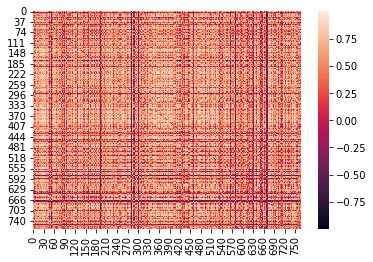

In [10]:
cosSimMatrixDocs = buildAdjacencyMatrixByCosineSimilarity(docVectors)
sns.heatmap(cosSimMatrixDocs)

Estimated number of clusters: 767
Estimated number of noise points: 442
Silhouette Coefficient: 0.062


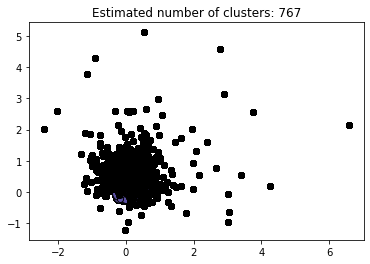

In [11]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.3, min_samples=10).fit(docVectors)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(docVectors, labels))

# Black removed and is used for noise instead.
unique_labels = labels
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = docVectors[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = docVectors[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

### Building Networks and Partitioning Communities

In [13]:
# initial community partition

# column to build adajency matrix 
adjColumnNameDoc = "ngram_lc_tagged_doc"

print("Building word co-occurence Adjacency Matrix...")
t0 = time()
dfBOW = getBackOfWordsDF(df, adjColumnNameDoc)
coocAdjMatrix = buildAdjacencyMatrixByCoOccurence(dfBOW)
print("Done in %0.3fs.\n" % (time() - t0))

print("Building Doc2Vec cosine similarity Adjacency Matrix...")
t0 = time()
T = 0.95 # hyperparameter
cosSimMatrix = buildAdjacencyMatrixByCosineSimilarity(docVectors)
cosSimMatrix[cosSimMatrix < T] = 0
cosSimMatrix[cosSimMatrix >= T] = 1
print("Done in %0.3fs.\n" % (time() - t0))

print("Building Networkx Graphs...")
t0 = time()
Gcossim = nx.from_numpy_array(cosSimMatrix)
Gcooc = nx.from_numpy_array(coocAdjMatrix)
print("Done in %0.3fs.\n" % (time() - t0))

community_generator = nx.algorithms.community

print("Building Louvain Partitions...")
t0 = time()
communitySetsCossineSim = community_generator.louvain_communities(Gcossim, resolution=0.1)
communitySetsCooc = community_generator.louvain_communities(Gcooc, resolution=0.1)
print("Done in %0.3fs.\n" % (time() - t0))


print("Adding Node Metadata...")
t0 = time()
graphList = [(coocAdjMatrix, Gcooc, communitySetsCooc, "co-occurence"), (cosSimMatrix, Gcossim, communitySetsCossineSim, "vector cosine similarity")]
for graphs in graphList:
    print("Beginning " + graphs[3] + "...\n")
    numCommunities = 0
    numNodes = len(df)
    nodes = list(range(numNodes))
    scalingFactor = 5. # scales the node size for visibility
    communitySets = graphs[2]
    G = graphs[1]
    adjMatrix = graphs[0]

    node_to_community = {}

    for set in communitySets:
        for x in set:
            node_to_community[x] = numCommunities
        numCommunities = numCommunities + 1

    for n in nodes:
        # 'title': hash (i.e. dataframe index)
        # 'group': partition
        # 'value': topic (empty for now)
        # 'size': normalized YAKE score
        G.nodes[n]["title"] = df.index[n] # this (clearly) doesn't work for matrices based on words (e.g. cooccurence)
        G.nodes[n]["group"] = node_to_community[n]
        G.nodes[n]["size"] = df["normalized_term_freq"][n] * scalingFactor

    # remove nodes apart of sparse communities

    community_sets_pared = []
    X = 3

    for com in communitySets:
        if (len(com) < X): # bypasses communities with fewer than X nodes
            continue
        else:
            community_sets_pared.append(com)

    nodes_to_keep = list(itertools.chain(*community_sets_pared))

    print("Adjacency Matrix size before: " + str(adjMatrix.shape))
    adjMatrixReduced = (adjMatrix[nodes_to_keep].T)[nodes_to_keep].T  # https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
    print("Adjacency Matrix size after: " + str(adjMatrixReduced.shape))

    nodes_to_remove = subtractListsOfInts(nodes, nodes_to_keep)
    G.remove_nodes_from(nodes_to_remove)

    numCommunitiesRemoved = numCommunities - len(community_sets_pared)
    print("Number of communities removed: " + str(numCommunitiesRemoved))

    numCommunities = numCommunities - numCommunitiesRemoved
    print("Number of communities remaining: " + str(numCommunities) + "\n")
print("Done in %0.3fs.\n" % (time() - t0))

Building word co-occurence Adjacency Matrix...
Done in 3.999s.

Building Doc2Vec cosine similarity Adjacency Matrix...
Done in 5.040s.

Building Networkx Graphs...
Done in 0.051s.

Building Louvain Partitions...
Done in 0.123s.

Adding Node Metadata...
Beginning co-occurence...

Adjacency Matrix size before: (1333, 1333)
Adjacency Matrix size after: (1331, 1331)
Number of communities removed: 1
Number of communities remaining: 3

Beginning vector cosine similarity...

Adjacency Matrix size before: (768, 768)
Adjacency Matrix size after: (675, 675)
Number of communities removed: 84
Number of communities remaining: 3

Done in 0.033s.



##### Matrix Heat Maps

<AxesSubplot:>

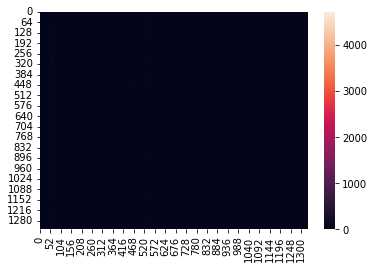

In [14]:
sns.heatmap(coocAdjMatrix)

It's rather apparent from the co-occurence matrix that using the full dictionary of words in the dataset is very sparse.

<AxesSubplot:>

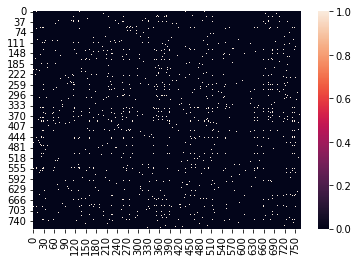

In [15]:
sns.heatmap(cosSimMatrix)

### Network/Topic Visualization

PyVis

In [16]:
# input the network you would like to visualize below as a NetworkX object in the first parameter
# recommended to only run this after validating the network with the above graphs and statistics
# if it is taking a while to run/load the image, set _physics=False
visualizeNetworkHTML(Gcossim, _filename="test vector cosine.html", _width="3840px", _height="2160px", _physics=True)

Key nodes

In [ ]:
# bridge node
df.loc["3bad1c0f3b983ab81ddff3f5e90e687310269d16"]

In [ ]:
df.loc["3bad1c0f3b983ab81ddff3f5e90e687310269d16"]["ngram_lc"]